# Toxic Comments Classification - NLP & ML Project

With the advent of social networks, blogs and online chats the human psychology is changing: **likes, comments and tags have a real and concrete role in our lives**, going from a "virtual" world to reality. The impact of **toxic comments affects the engagement of users** in conversations. Many people stop expressing themselves and give up in presence of a threat of abuse and harassment online.

This means that **platforms and users loose the ability to be involved in constructive conversations.**  Moreover, the severity and viciousness of these comments has evolved into something much more sinister such as the 2021 US capitol riots and several cases of suicide, even among very young people. Identify toxic comments can **lead communities to facilitate and improve online conversations and exchange of opinions**.

## Abstract
After importing the data, that is raw comments, we proceed with an **initial cleaning of the text**, with the aim of removing textual elements that are not to be considered during the subsequent analysis (mentions, hashtags, repeated spaces, ...). We then proceed with some **classic NLP tasks, namely the removal of stopwords, tokenization and stemming.** The raw text is then transformed into a list of words, called tokens. **We turn the resulting words into numbers, more precisely arrays of numbers.** We will use three approaches: the first is very simple and based on word frequencies (TF-IDF), the others are more complex (Word2Vec, Doc2Vec). **The vectors resulting from these operations will be used by machine learning models** to make predictions about new comments. In particular **we will test different models**: logistic regression, naive bayes and linear svm. At the end we will choose **the combination of encoding and model that perform better**, and we will proceed with the **fine tuning, looking for the best parameters and the best threshold.** I also developed **a demo application** for this classifier, hosted on my Hugging Face. 

The following image shows graphically the workflow.

# ![title](./img/ToxicCommPipe.png)

## Steps of the Project
This is an end-to-end project covering all the necessary steps from text preprocessing to final classification and tuning.

The project consists of the following main sections (wich may consist of different subsections):

1. **Importing Tools**
2. **Importing Data and Cleaning**
3. **Preprocessing Text - NLP pipeline**
4. **Some Visualization**
5. **Splitting the data in training and testing sets**
6. **Different Embeddings: TF-IDF, Word2Vec, Doc2Vec**
7. **Dealing with Imbalanced Classes**
8. **Features Normalization**
9. **Algorithm Selection and Hyperparameter tuning**
10. **Performance of the model**
11. **ROC, AUC, Precision-Recall Curve**
12. **Threshold Tuning**
13. **Demo App & Further Steps**
14. **Drawing conclusions — Summary**

## Dataset

The dataset for this project is hosted on Kaggle and was part of a competition. According to the description on Kaggle, *The Conversation AI team, a research initiative founded by Jigsaw and Google (both a part of Alphabet) are working on tools to help improve online conversation. One area of focus is the study of negative online behaviors, like toxic comments.*

**The goal of this project is slightly different from the original one: here i will perform a binary classification of the comments** (instead of the multiclass multioutput defined in the original competition).

I will use only the train set provided by Kaggle and i will proceed with the usual splitting into train and test sets. **The dataset consists of 143346 non-toxic comments and 16225 toxic comments. A comment is considered toxic if belongs to at least one of the toxicity categories provided in the original dataset.** The original toxicity labels have been assigned in a manual way by humans, according to the description of the dataset available on Kaggle.

The dataset contains the raw comments, extracted as they were originally posted by users. **This comments have been extracted from Wikipedia talks pages.** For more details about the dataset, please refer to the competition page on Kaggle, at <https://www.kaggle.com/competitions/jigsaw-toxic-comment-classification-challenge>.

## 1. Importing Tools

For this project are required the common data science libraries. In addition i use **imblearn** to deal with imbalanced datasets, **nltk** and **spacy** for basic NLP tasks, **gensim** for advanced text embedding and **wordcloud** to provide visualizations base on the words in the corpus.

In [143]:
# UTILITY
from PIL import Image
from joblib import dump
import pandas as pd
import numpy as np
from collections import Counter
from sklearn.preprocessing import MinMaxScaler, Normalizer
import warnings

# IMBALANCED LEARN
from imblearn.over_sampling import SMOTE

# NLP
import re
from nltk.corpus import wordnet
from nltk.tokenize import word_tokenize
from nltk import SnowballStemmer
import spacy
from gensim.models.doc2vec import Doc2Vec, TaggedDocument, Word2Vec
from gensim.test.utils import get_tmpfile
from sklearn.feature_extraction.text import TfidfVectorizer

# MODELS
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB

# EVALUATION
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score,\
     f1_score, roc_auc_score, roc_curve, precision_recall_curve

# VISUALIZATION
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# INIT
warnings.filterwarnings('ignore')
NUM_OF_THREADS = 10 # set > 1 to use multithreading support

## 2. Importing Data and Cleaning

The first step of this project is importing and **cleaning textual data**. For this purpose we start with some **basic regex-based text cleaning** operations. 

In particular:

1. remove numbers and words concatenated with numbers (IE h4ck3r)
2. remove emails and mentions (words with @)
3. remove hashtags (words with #)
4. remove URLs
5. replace the ASCII '�' symbol with '8'
6. remove multiple spaces

In [2]:
# read data from csv file
data = pd.read_csv("./data/train.csv")
# drop na and reset index
data.dropna(inplace=True)
data.reset_index(inplace=True, drop=True)
# column name to work with
name = "comment_text"

In [3]:
# function to clean the text performin some simple regex pattern matching
def apply_regex(corpus):
    corpus = corpus.apply(lambda x: re.sub("\S*\d\S*"," ", x))          # removes numbers and words concatenated with numbers (IE h4ck3r)
    corpus = corpus.apply(lambda x: re.sub("\S*@\S*\s?"," ", x))        # removes emails and mentions (words with @)
    corpus = corpus.apply(lambda x: re.sub("\S*#\S*\s?"," ", x))        # removes hashtags (words with #)
    corpus = corpus.apply(lambda x: re.sub(r'http\S+', ' ', x))         # removes URLs
    corpus = corpus.apply(lambda x: re.sub(r'[^a-zA-Z0-9 ]', ' ',x))    # keeps numbers and letters
    corpus = corpus.apply(lambda x: x.replace(u'\ufffd', '8'))          # replaces the ASCII '�' symbol with '8'
    corpus = corpus.apply(lambda x: re.sub(' +', ' ', x))               # removes multiple spaces
    return corpus

In [4]:
# apply the function and clean the data
data[name] = apply_regex(data[name])

As we said, in this project we focus **on a binary classification task**, so we create a new **binary column called *label*.** The value of this attribute is 1 if the comments belongs to at least oone of the toxicity categories.

In [5]:
# ASSIGN A BINARY LABEL -- 1 is toxic, 0 is not
data["label"] = np.where(data["toxic"]==1, 1, 
                np.where(data["severe_toxic"]==1, 1, 
                np.where(data["obscene"]==1, 1, 
                np.where(data["threat"]==1, 1,
                np.where(data["insult"]==1, 1,
                np.where(data["identity_hate"]==1, 1, 0))))))

After this simple operation, we check if we are in an imbalanced situation. **The imbalanced ratio is almost 9:1**. I will deal with this problem using **SMOTE to oversample the minority class in order to balance the classes** with a 1:1 ratio. The following instruction shows the actual samples for each class. The balancing process **will be performed after the encoding** of the text into vecotrs, due to the fact that SMOTE works on numerical data.

In [6]:
# Count of samples for each class
Counter(data["label"])

Counter({0: 143346, 1: 16225})

## 3. Preprocessing Text - NLP pipeline

After the inital steps, we need to proceed with a **NLP pipeline**. There are some steps which are common for NLP problems like text classification, in particular we need to:

1. Remove stop words and tokenize the text
2. Stemming the tokens

**Tokens are the building blocks of Natural Language**. With tokenization we break a text into smaller units, named tokens. Tokenization can be performed in different ways, for example by separating at the level of words, characters or subwords. **In this project we tokenize words.**

**Stop word removal** is another common process in NLP. The goal is **removing common words that appears in most of the documents** in the corpus. **This words have no significance** since carry a lower amount of information. Generally, articles and pronouns are identified as stop words.

**Stemming** is a technique used to take words at their root form (remove inflection), helping to normalize text. Same words with different inflection can be redundant in the NLP process.

In [7]:
# TOKENIZE TEXT - we use the Spacy library stopwords
spacy_model = spacy.load("en_core_web_sm")
stop_words = spacy_model.Defaults.stop_words

In [8]:
# TOKENIZE TEXT and STOP WORDS REMOVAL - execution (removes also the words shorter than 2 and longer than 15 chars)
def tokenize(doc):
    tokens_1 = word_tokenize(str(doc))
    return [word.lower() for word in tokens_1 if len(word) > 1 and len(word) < 15 and word not in stop_words and not word.isdigit()]
    
data["tokenized"] = data[name].apply(tokenize)

In [9]:
# STEMMING
stemmer = SnowballStemmer(language="english")

def applyStemming(listOfTokens):
    return [stemmer.stem(token) for token in listOfTokens]

data['stemmed'] = data['tokenized'].apply(applyStemming)

**The final result** of the NLP preprocessing is shown in the next cell. **We can see the result of all the steps**, from raw text to stemmed text. For the next steps, **we will use the stemmed text.**

In [119]:
data.sample(3)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,label,tokenized,stemmed
154328,ac6c51e5dcc4914e,Nansen passport You probably know or do not th...,0,0,0,0,0,0,0,"[nansen, passport, you, probably, know, nansen...","[nansen, passport, you, probabl, know, nansen,..."
128740,b0802286269e63c1,E September Best status from NRL kts mb first...,0,0,0,0,0,0,0,"[september, best, status, nrl, kts, mb, appeared]","[septemb, best, status, nrl, kts, mb, appear]"
86488,e759b00191ad39f0,Yeah Wikipedia I been a bad boy Masser yeah so...,0,0,0,0,0,0,0,"[yeah, wikipedia, bad, boy, masser, yeah, free...","[yeah, wikipedia, bad, boy, masser, yeah, free..."


## 4. Some Visualizations

In this section we go throught some visualizations that will help us to better understand the data we are working with. This visualizations are **word clouds of the toxic and non-toxic raw comments.** This visualization are obtained using the *wordcloud* library. Word Clouds are visual displays of text data for simple text analysis. **Word Clouds display the most prominent or frequent words in a body of text.** 

First we divide toxic and non-toxic comment based on the binary label.

In [11]:
# TAKING TOXIC COMMENTS
threat_text = data[data["label"]==1]["comment_text"]
neg_text = pd.Series(threat_text).str.cat(sep=' ')

# TAKING NON-TOXIC COMMENTS
non_threat_text = data[data["label"]==0]["comment_text"]
pos_text = pd.Series(non_threat_text).str.cat(sep=' ')

At this point, we generate the wordclouds. The choice of the color palette is arbitrary, i tried to select colors that enfatize the toxicity of the words.

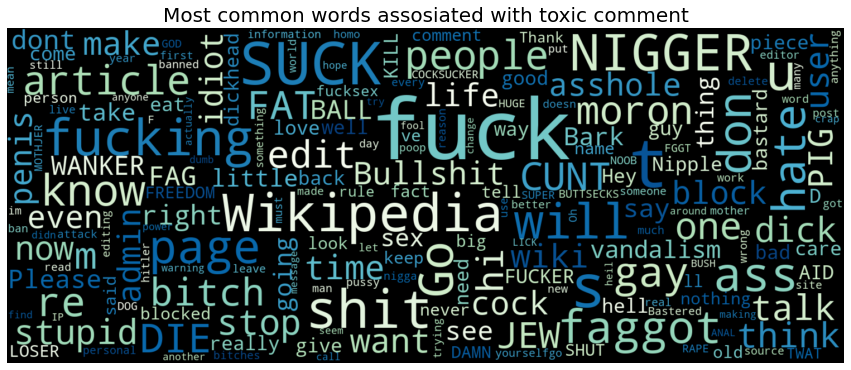

In [130]:
# Generate toxic word cloud
wordcloud_neg = WordCloud(collocations=False, 
                            width=1500, 
                            height=600, 
                            max_font_size=150
                        ).generate(neg_text)
plt.figure(figsize=(15, 10))
plt.imshow(wordcloud_neg.recolor(colormap="GnBu"), interpolation='bilinear')
plt.axis("off")
plt.title(f"Most common words assosiated with toxic comment", size=20)
plt.show()

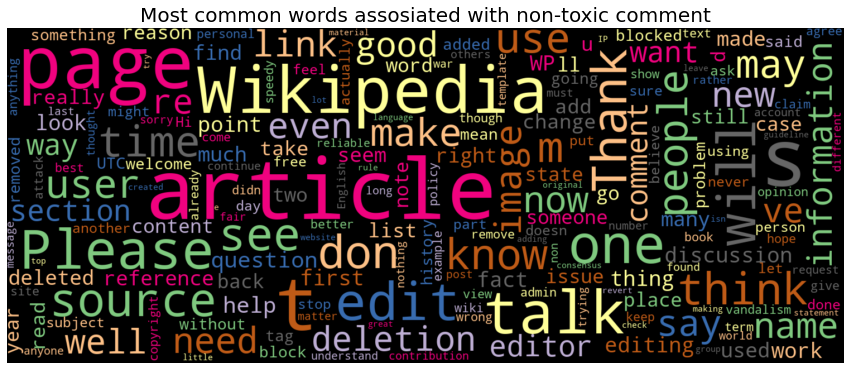

In [13]:
#Generate non-toxic word cloud
wordcloud_pos = WordCloud(collocations=False, 
                            width=1500, 
                            height=600, 
                            max_font_size=150
                        ).generate(pos_text)
plt.figure(figsize=(15, 10))
plt.imshow(wordcloud_pos.recolor(colormap="Accent"), interpolation='bilinear')
plt.axis("off")
plt.title(f"Most common words assosiated with non-toxic comment", size=20)
plt.show()

An interesting fact we can spot is that **some words are frequent in both category**. This underline that **toxity not only regard singular words, but also the context** in which the words are used in (surrounding words).

## 5. Splitting the Data in Training and Testing sets

The next step consist of **splitting the dataset into train and test sets** using the usual *train_test_split* functionality provided by sklearn.

In [14]:
# Even if for the competition on kaggle the gave also the "test" dataset, i decided to use only the "train" set as a unique dataset.
X_train, X_test, y_train, y_test = train_test_split(data["stemmed"], data["label"], random_state=42)

## 6. Different Embeddings: TF-IDF, Word2Vec, Doc2Vec

Now that we have the test and train sets, we need to **encode the stemmed text**, that now is a vector of words, **into a Vector Space Model (VSM)** that means **converting the array of words into an array of numbers**, that will be used by a machine learning algorithm for the actual classification task.

Converting text into a VSM is a **non trivial aspect, involving some domain-based reasoning.** In this project i will encode the text using **three different methods**:

1. Basic TF-IDF (frequency based) approach
2. More advanced Word2Vec model (custom trained on the corpus)
3. More advanced Doc2Vec model (custom trained on the corpus)

This approaches will be explained in the following subsections.

### TF-IDF Vectorizer

**Term Frequency–Inverse Document Frequency** (TF-IDF) is a popular technique used to **compute words importance across all the documents** in the corpus. In particular, the assumption is that a word that appears more times in a document but doesn't appear in all the others, is important for that document. TF-IDF **assigns a weight to each word based on the occurence frequency**. At the end, words that are frequent in general will have a lower weight (carry less information for a specific document).

We represents a set of words (for example a comment) with an **array containing the scores of the words**.

This methods belongs to the "Bag of Words" category and share **some disadvantages** in respect to more advance methods. For instance, **word order is lost and the context is not considered**.

In [15]:
# commodity methos to avoid running tokenization again
def do_nothing(lemmas):
    return lemmas

The stemmed text is passed to the sklearn *TfidfVectorizer* specifying a number of features equal to 500. This is an arbitrary choice, and in order to have a fair comparison with other method, this parameter will be setted to 500 for all the three methods.

In [16]:
# encodin text into vectors
tfid = TfidfVectorizer(lowercase=False, tokenizer=do_nothing, max_features=500)

train_vectors_tfidf = tfid.fit_transform(X_train).toarray()
test_vectors_tfidf = tfid.transform(X_test).toarray()

### Word2Vec: Model Creation and Persistence Store

Word2vec is a NLP technique published in 2013. This algorithm uses a **neural network to learn word representation** from a large corpus of text. The goal for the model is to **learn a semantic representation** of the words. That means similar words have a similar representation and are "near" in the Vector Space Model. 

Word2Vec represent each word as a vector, but in this project we are working with comments, that are a set of words. In order to obtain a representation of a document (a comment) we **take the average of the representations of the words that make that document (comment).** This is a very simple but still effective approach.

We use Word2Vec in order to create a **continuous bag-of-words (CBOW) representation**. With CBOW the current words is predicted from a window of contextual words. Note that the order of the context words is not taken into consideration.

We start by setting the parameter for the train of the model. Once ther model is trained, we save it on the disk.

In [17]:
# execute only if in order to retrain the model or if the trained model is not present in the folder "./w2vec.model"
# seting the parameter for the w2v model
w2v = Word2Vec(
                sg=0,                   # 1 for skip-gram, 0 for CBOW
                vector_size=500,        # size of the resulting vector
                workers=NUM_OF_THREADS, # multithreading
                epochs=100,             # number of epochs
                seed=42                 # seed for reproducibility
            )            

# building the vocabulary and training the model
w2v.build_vocab(X_train, progress_per=50000)
w2v.train(X_train, total_examples=w2v.corpus_count, epochs=30, report_delay=1)

# saving the model to the disk in order to avoid training again
w2v.save("w2vec.model")
print("Model Saved")

Model Saved


### Word2Vec Embedding using the Trained Model

At this point, we can load the trained model and use it for the actual embedding.

In [18]:
wordVec = Word2Vec.load("./w2vec.model").wv

The following function takes the tokens of each document (comment) and look up in the model for the vectorial representation of each token. All the representations of the tokens of each document are averaged together in order to get a vectorial representation of the whole comment. **Basically a comment is represented as the average of the words representations of the words that make that comment.**

In [19]:
# Creating a feature vector by averaging all embeddings for all sentences
def embedding_feats(corpus, w2v_model):
    DIMENSION = 500
    zero_vector = np.zeros(DIMENSION)
    feats = []
    for tokens in corpus:
        feat_for_this =  np.zeros(DIMENSION)
        count_for_this = 0 + 1e-5 # to avoid divide-by-zero 
        for token in tokens:
            if token in w2v_model:
                feat_for_this += w2v_model[token]
                count_for_this +=1
        if(count_for_this!=0):
            feats.append(feat_for_this/count_for_this) 
        else:
            feats.append(zero_vector)
    return feats


train_vectors_w2v = embedding_feats(X_train, wordVec)
test_vectors_w2v = embedding_feats(X_test, wordVec)

The resulting vectors will be used in the next steps.

### Doc2Vec: Model Creation and Persistence Store

**Doc2Vec model**, as opposite to Word2Vec model, is used to **create a vector representation of a group of words** considered as a single unit. With this approach we directly represent a document (comment) into a vector. Doc2Vec is **based on Word2Vec but in addition has a unit named Paragraph Vector**. 

During the trainin phase, the paragraph vector is learned together with the words. The words representation is shared across all the documets and permit to learn the paragraph vector.

The **Distributed Bag-Of-Words (DBOW)** model helps in guessing the context words from a target word. The **Distributed Memory (DM)**  model helps in guessing a single word from a context of words. In this project we use the DBOW approach.

We prepare the data to be trained and set up the parameters. Once the model is trained, we save it on the disk.

In [20]:
# execute only if in order to retrain the model or if the trained model is not present in the folder "./d2v_comments.model"
#prepare training data in doc2vec format:
train_doc2vec = [TaggedDocument((d), tags=[str(i)]) for i, d in enumerate(X_train)]

#Train a doc2vec model to learn representations.
model = Doc2Vec(
                vector_size=500,                # size of the resulting vector
                dm=0,                           # dm=0 -> we use a DBOW representation
                epochs=100,                     # number of epochs
                seed=42,                        # seed for reproducibility
                workers=NUM_OF_THREADS,         # multithreading
                )        

# building the vocabulary and training the model
model.build_vocab(train_doc2vec)
model.train(train_doc2vec, total_examples=model.corpus_count, epochs=model.epochs)

# saving the model to the disk in order to avoid training again
model.save("d2v_comments.model")
print("Model Saved")

Model Saved


### Doc2Vec Embedding using the Trained Model

We load the trained model and with the *infer_vector* method we generate a vectorized representation of each document. This instruction will take some time.

In [21]:
#Infer the feature representation for training and test data using the trained model
model_d2v= Doc2Vec.load("d2v_comments.model")

#infer in multiple steps to get a stable representation. 
train_vectors_d2v =  [model_d2v.infer_vector(tokens, epochs=70) for tokens in X_train]
test_vectors_d2v = [model_d2v.infer_vector(tokens, epochs=70) for tokens in X_test]

At the end of this section we have **three different encodings obtained with different methods**. The next section is about dealing with imbalanced classes.

## 7. Dealing with Imbalanced Classes

The dataset is **imbalanced with a ratio of almost 9:1.** In order to deal with this problem we use the *imbalanced learn* libraries. In particular i'm using the **SMOTE (synthetic minority oversampling technique) algorithm to produce new synthetic data points**. This new samples are generated using vector operations (this is why this operation must be done after the vector encoding phase). With the default parameters, the algorithm will **completely balance the dataset**, that will end up having a ratio of 1:1, that means same number of observation for both the classes.

In particular, SMOTE selects a minority class instance (a) at random and finds its k nearest minority class neighbors. Then, one of the k nearest neighbors is choosen at random (b). Using any distance metric, the difference in distance between the feature vector (a) and its neighbor (b) is computed. Now, this difference is multiplied by any random value in (0,1] and is added to the previous feature vector (a) in order to obtain the synthetic sample. 

The operation is applied to train and test data resulting from each of the encoding methods used, in order to keep different approaches separated. I decided to use SMOTE because according to *"V. Rupapara et al.: Impact of SMOTE on Imbalanced Text Features for Toxic Comments Classification"* this approach is very effective in this kind of applications. After some tests i realized that this operations really seems to **boost the performance of the final classification model** for this project.

In [23]:
# SMOTE for the tf-idf encoding
sm_tfidf = SMOTE(random_state=42, n_jobs=NUM_OF_THREADS)
train_vectors_tfidf, y_train_tfidf = sm_tfidf.fit_resample(train_vectors_tfidf, y_train)
test_vectors_tfidf, y_test_tfidf = sm_tfidf.fit_resample(test_vectors_tfidf, y_test)

In [24]:
# SMOTE for the W2V encoding
sm_w2v = SMOTE(random_state=42, n_jobs=NUM_OF_THREADS)
train_vectors_w2v, y_train_w2v = sm_w2v.fit_resample(train_vectors_w2v, y_train)
test_vectors_w2v, y_test_w2v = sm_w2v.fit_resample(test_vectors_w2v, y_test)

In [25]:
# SMOTE for the D2V encoding
sm_d2v = SMOTE(random_state=42, n_jobs=NUM_OF_THREADS)
train_vectors_d2v, y_train_d2v = sm_d2v.fit_resample(train_vectors_d2v, y_train)
test_vectors_d2v, y_test_d2v = sm_d2v.fit_resample(test_vectors_d2v, y_test)

## 8. Features Normalization

In this section **we normalize the data** using *normalizer* from sklearn. *normalizer* **normalizes samples individually to unit norm.** Each sample is rescaled independently so that its norm (l1, l2 or inf) equals one.
Scaling is a **common operation for text classification**. We execute a normalization for each method used to encode the text. **The resulting normalized vectors will be fed as input to the classification models.** After some tests, this approach seems to improve the final performance of the model.

We normalize the vectors obtained from the different encoding techniques.

### TF-IDF Normalization

In [26]:
# NORMALIZING TF-IDF VECTORS
norm_TFIDF = Normalizer(copy=False)
norm_train_tfidf = norm_TFIDF.fit_transform(train_vectors_tfidf)
norm_test_tfidf = norm_TFIDF.transform(test_vectors_tfidf)

### Word2Vec Normalization

In [27]:
# NORMALIZING WORD2VEC VECTORS
norm_W2V = Normalizer(copy=False)
norm_train_w2v = norm_W2V.fit_transform(train_vectors_w2v)
norm_test_w2v = norm_W2V.transform(test_vectors_w2v)

### Doc2Vec Normalization

In [28]:
# NORMALIZING DOC2VEC VECTORS
norm_D2V = Normalizer(copy=False)
norm_train_d2v = norm_D2V.fit_transform(train_vectors_d2v)
norm_test_d2v = norm_D2V.transform(test_vectors_d2v)

At the end of this section, **we have a train and a test set for each encoding method used.** This vectors will be used for the classification task.

## 9. Algorithm Selection & Hyperparameter Tuning

In this section **different baseline models will be tested** for each encoding methods used.
Basically for each encoding techniques (TF-IDF, Word2VEc, Doc2Vec) will be tested 3 models (for a total of 9 models):

1. Linear SVC baseline
2. Logistic Regression baseline
3. Naive Bayes baseline

A custom function will be used to **reason on the performance of these models** and, at the end, one model will be selected. The selected combination of model and encoding will be fine tuned.

We create a custom function to test programmatically different model baselines.

In [29]:
# generic function to create different models
def create_models(seed=42, classW="balanced"):
    models = []
    # we can append more than one model to test
    models.append(('LinearSVC', LinearSVC(random_state=seed, class_weight=classW)))
    models.append(('Logit', LogisticRegression(random_state=seed, class_weight=classW, n_jobs=NUM_OF_THREADS, max_iter=300)))
    models.append(('NaiveBayesMN', MultinomialNB()))
    return models

In order to evaluate performance of different techniques and models, a custom function is used. The following function **return a dataframe with some evaluation metrics**. <br><br>
The metrics considered are:
* Accuracy
* F1 score
* Recall
* Precision
* Specificity
* True Positive num
* True Negative num
* False Positive num
* False Negative num
* Size of the Test Set

In [30]:
# Returns a dataframe with classification metrics and confusion matrix values
def make_classification_score(y_test, predictions, modelName):
    tn, fp, fn, tp = confusion_matrix(y_test, predictions).ravel()
    prec=precision_score(y_test, predictions)
    rec=recall_score(y_test, predictions)
    f1=f1_score(y_test, predictions)
    acc=accuracy_score(y_test, predictions)
    # specificity
    spec=tn/(tn+fp)

    score = {'Model': [modelName], 'Accuracy': [acc], 'f1': [f1], 'Recall': [rec], 'Precision': [prec], \
        'Specificity': [spec], 'TP': [tp], 'TN': [tn], 'FP': [fp], 'FN': [fn], 'y_test size': [len(y_test)]}
    df_score = pd.DataFrame(data=score)
    return df_score

Another custom function is used in order to **automatically train - test - evaluate** all the models defined.

In [31]:
# generic function to test the created models
def test_models(models, X_train, y_train, X_test, y_test):
    score = pd.DataFrame()
    for name, model in models:
        # in case of nayve bayes we scale the values
        if name=="NaiveBayesMN":
            scaler = MinMaxScaler()
            X_train = scaler.fit_transform(X_train)
            X_test = scaler.transform(X_test)
        # fit the model with the training data
        model.fit(X_train, y_train)
        # make predictions with the testing data
        preds = model.predict(X_test)
        # compute score
        tmp = make_classification_score(y_test, preds, name)
        score = pd.concat([score, tmp])
    return score

We proceed with the actual **creation of the models**, after this step, different encoding approaches are tested in the following sub sections.

In [32]:
models = create_models()

### Testing the TF-IDF Approach

In [33]:
results = test_models(models, norm_train_tfidf, y_train_tfidf, norm_test_tfidf, y_test_tfidf)
results

,Model,Accuracy,f1,Recall,Precision,Specificity,TP,TN,FP,FN,y_test size
0,LinearSVC,0.831333,0.822621,0.782218,0.867426,0.880449,28030,31550,4284,7804,71668
0,Logit,0.831082,0.822815,0.784423,0.865159,0.877742,28109,31453,4381,7725,71668
0,NaiveBayesMN,0.823394,0.813382,0.769744,0.862265,0.877044,27583,31428,4406,8251,71668


### Testing the Word2Vec Approach

In [34]:
results = test_models(models, norm_train_w2v, y_train_w2v, norm_test_w2v, y_test_w2v)
results

,Model,Accuracy,f1,Recall,Precision,Specificity,TP,TN,FP,FN,y_test size
0,LinearSVC,0.927346,0.926539,0.916364,0.936942,0.938327,32837,33624,2210,2997,71668
0,Logit,0.926857,0.925988,0.915109,0.937128,0.938606,32792,33634,2200,3042,71668
0,NaiveBayesMN,0.856910,0.851920,0.823213,0.882701,0.890607,29499,31914,3920,6335,71668


### Testing the Doc2Vec Approach

In [35]:
results = test_models(models, norm_train_d2v, y_train_d2v, norm_test_d2v, y_test_d2v)
results

,Model,Accuracy,f1,Recall,Precision,Specificity,TP,TN,FP,FN,y_test size
0,LinearSVC,0.928504,0.927676,0.917062,0.938539,0.939945,32862,33682,2152,2972,71668
0,Logit,0.928629,0.927835,0.917620,0.938279,0.939638,32882,33671,2163,2952,71668
0,NaiveBayesMN,0.889086,0.883283,0.839370,0.932044,0.938801,30078,33641,2193,5756,71668


### RandomizedSearch to find the Best Parameters

As result of the previous section, we identified a good encoding and a good model: **Logistic Regression with Doc2Vec seems better than the other candidates**. Now we perform an **hyperparameter search** in order to **find the best parameters**. For this purpose we **set up a parameter grid for the model**. The complete list of parameter for each model can be found on the documentation provided by sklearn.

In [36]:
#### LOGIT PARAM GRID ####
logit_param = {"penalty" : ["l1","l2","elasticnet"],
                "tol" : [0.0004, 0.004, 0.04, 0.4],
                "C" : [0.5, 1, 1.5, 2, 5],
                "random_state" : [42],
                "solver" : ["saga", "sag", "liblinear", "lbfgs", "newton-cg"],
                "max_iter" : [200,400,600,800]
            }

We run the **randomized search, with a cross validation folds set to 8 and 15 iterations.** At the end we can get also the best parameters found by the search. Here another option is *GridSearchCV* that tests all the possible combinations of parameters. Even if a grid search represents a more exhaustive search, it turns out to be computationally too complex and long compared to a randomized search. Basically, in contrast to GridSearchCV, not all parameter values are tried out, but rather a fixed number of parameter settings is sampled from the specified distributions. **The number of parameter settings that are tried is given by n_iter.** 

The random search approach could lead to a non-optimal combination of parameter (a sort of local optimum), so **we are not sure that we have found the real best parameters**.

In [92]:
# running the search and fitting the model
final_model = RandomizedSearchCV(LogisticRegression(), 
                                logit_param, 
                                random_state=42, 
                                cv=8, 
                                verbose=-1, 
                                n_jobs=NUM_OF_THREADS, 
                                n_iter=15)
                                
final_model.fit(norm_train_d2v, y_train_d2v)
# make predictions with the testing data
preds = final_model.predict(norm_test_d2v)
# compute score
make_classification_score(y_test_d2v, preds, "logit_tuned_d2v")

,Model,Accuracy,f1,Recall,Precision,Specificity,TP,TN,FP,FN,y_test size
0,logit_tuned_d2v,0.928992,0.928278,0.919043,0.937701,0.938941,32933,33646,2188,2901,71668


In [93]:
# return the possibly best estimator
final_model.best_estimator_

LogisticRegression(C=2, max_iter=600, penalty='l1', random_state=42,
                   solver='liblinear', tol=0.004)

The previous step returned the best parameters for the algorithms. Now we can use the *predict_proba()* method to **predict the probability of belonging to one class or another.** We will use this probabilities in other to tune a custom threshold.

In [94]:
# getting predicted probability values
probability = final_model.predict_proba(norm_test_d2v)

We conclude this section by **materializing the fitted model on the disc**, in order to use it in other application or avoid retraining.

In [108]:
dump(final_model, 'toxicCommModel.joblib')

['toxicCommModel.joblib']

## 10. Performance of the Model

Evaluating the performance of the model is a very important step. In order to do so, i created two custom functions. The first to **convert the probability of belonging to a class into a final binary class** using a specified threshold. The second one return a dataframe with all the **metrics for the evaluation of the model**. This functions are described in the following sections. We use the probability from the previous step to assign to each sample a final class.

### Custom Function to convert a probability to a class using a threshold t

This function takes the probability from *predict_proba()* and a threshold value. **Then convert the probability to a binary class [0,1]**. Note that in the function we **consider the prbability to belong to the "1" class (toxic comment).**

In [95]:
# from probability to class value based on custom threshold
def probs_to_prediction(probs, threshold):
    pred=[]
    for x in probs[:,1]:
        if x>threshold:
            pred.append(1)
        else:
            pred.append(0)
    return pred

### Model Evaluation with a Threshold = 0.5
Before doing some advanced threshold tuning, it is important to **check that results with a threshold t=0.5 are the same obtained previously** using the *predict()* method. **Results are consistent because t=0.5 is the default threshold implementated by the algorithm.**

In [96]:
predictions=probs_to_prediction(probability, 0.5)
make_classification_score(y_test_d2v, predictions, "logit, t=0.5")

,Model,Accuracy,f1,Recall,Precision,Specificity,TP,TN,FP,FN,y_test size
0,"logit, t=0.5",0.928992,0.928278,0.919043,0.937701,0.938941,32933,33646,2188,2901,71668


The result is not bad and all the considered metrics are over .91. **We still have some False Positives and False Negatives**: this leads us to a **more advanced threshold tuning** in order to decide, based on the application, **which is the important metric to maximize** (precision or recall based on the cost of a FN and the cost of a FP)

## 11. ROC, AUC, Precision-Recall Curve

Before tuning the threshold of our classifier, in this section we plot different curves. This plots will help to decide the **"trade off" between all the metrics**. The threshold choice starts from this trade off.

### ROC AUC and Curve Plot

By definition an ROC curve (receiver operating characteristic curve) is a graph showing the **performance of a classification model at all the classification thresholds**. First we compute the Area Under The roc Curve (AUC) and then we plot the curve. **A value of the AUC=1 refers to a perfect classifier, AUC=0.5 refers to a random classifier.**

In [46]:
# calculate roc auc score
print("SVM: ROC AUC = %.4f" % roc_auc_score(y_test_d2v, probability[:, 1]))

SVM: ROC AUC = 0.9794


We got an **AUC value equal to 0.9794**, not bad. Now we **plot the curve**. The dots represent **different threshold values.**

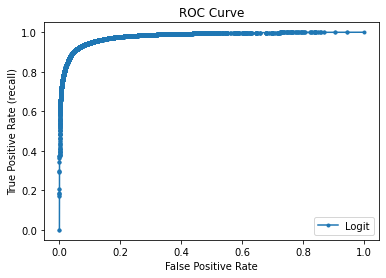

In [98]:
# calculate roc curve
model_fpr, model_tpr, _ = roc_curve(y_test_d2v, probability[:, 1])
# plot roc curve
plt.plot(model_fpr, model_tpr, marker='.', label='Logit')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (recall)')
plt.legend()
plt.title("ROC Curve")
plt.show()

### Precision-Recall Cruve Plot

In a situation of unbalanced classes it is better to use a Precision - Recall curve instead of a ROC curve. Even if we balanced the dataset, could be usefull to look at this curve anyway.<br>
The precision-recall curve presents the **tradeoff between precision and recall** at different threshold. **We can choose a value of the threshold that matches the desired values of precision and recall.**

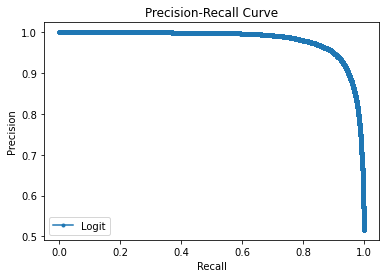

In [49]:
# calculate precision-recall curve
model_precision, model_recall, thresholds = precision_recall_curve(y_test_d2v, probability[:, 1])
# plot the curve
plt.plot(model_recall, model_precision, marker='.', label='Logit')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.title('Precision-Recall Curve')
plt.show()

## 12. Threshold Tuning

**The choice of the important metric** to maximize (precision vs recall) **depends on the domain and the application itself**. For example, in spam detection if an important email were marked as spam when it actually isn’t, this could be disastrous as you would miss it. As opposite, in medicine a false negative would be much more damaging.

**Based on the context** in which we use a toxic comments classification model, **we can decide which metric to maximize based on the cost of a false positive or false negative**, there is no a right or wrong answer here. In an application for kids (YouTube Kids) we would like to maximize the recall as a False Negative detains an higher misclassification cost. In another context we could maximize precision in order to avoid the reporting of non-toxic comments.

**Let's try, for instance, to maximize precision that means cost of FP > cost of FN.** This operation requires some tests at different thresholds until we are satisfied with the number of FN and FN.

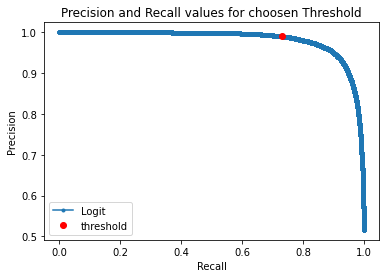

In [104]:
# plotting precision-recall curve with the choosen threshold
plt.plot(model_recall, model_precision, marker='.', label='Logit')
plt.plot(model_recall[43000], model_precision[43000], "ro", label="threshold")
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.title('Precision and Recall values for choosen Threshold')
plt.show()

The value of the choosen threshold is:

In [105]:
# print the threshold value
print("Threshold value = %.4f" % thresholds[43000])

Threshold value = 0.9378


As we see, the **number of false positive with this threshold is 266 and the precision is 0.9898**. On the other hand, the recall dropped to 0.730.

In [106]:
# choosen threshold results
predictions=probs_to_prediction(probability, thresholds[43000])
make_classification_score(y_test_d2v, predictions, "logit, custom t")

,Model,Accuracy,f1,Recall,Precision,Specificity,TP,TN,FP,FN,y_test size
0,"logit, custom t",0.861793,0.840998,0.73101,0.989947,0.992577,26195,35568,266,9639,71668


We can try also different solutions. **It is up to us to decide what is better given the actual costs** of misclassification.

## 13. Demo App & Further Steps

With the pipeline and the trained models, is possible to **develop a demo application with a GUI**. These models can also be **embedded in existing applications**.

For this purpose, i developed a demo application to play a bit with the tuned models. The application is hosted at <https://huggingface.co/spaces/EdBianchi/Social_Toximeter>.

The demo consist of **three sections**, the **first one allow to write a comment and display the probabilities** assigned to each class by the classifier.

<img src="./img/app1.png" width="550" height="350">

**The second one shows the final classification label for the comment at three different thresholds**, 0.5 is the default thresh, 0.937 is the thresh selected after the tuning and 0.999 is a more extreme thresh. **This allow to understand how the output class changes based on the threshold** (and the importance of choiching a correct threshold).

<img src="./img/app2.png" width="550" height="200">

**The last section shows the output of the NLP preprocerssing pipeline**, this are the tokens that are embedded using the trained D2V model.

<img src="./img/app3.png" width="500" height="350">

## 14. Drawing Conclusions - Summary

We started by **cleaning the data** and performing a common **NLP pipeline**. After, we used **different embedding methods**, from a frequency based one to more advanced ones. With the resulting vectors **we performed class balancing and normalization**. At the end we **tested different baseline** models and **tuned the hyperparameters** of the best performing model. At the end we selected a context in which precision is the important metric to maximize, and **we tuned the threshold**.

I am satisfied with this result of this work, and surprised about the effect of SMOTE on the performance of the model. I think that working on natural language, as well as being the basis of important everyday applications, is a stimulating and intriguing challenge: the whole society in which we live is based on language (which allows us to communicate).

I tried to follow and cover **all the main steps involved in a real Data Science pipeline** applied to a NLP project and be **as precise as possible in the description** of all the passages. Although the notebook shows a linear process, **machine learning projects tend to be iterative rather than linear processes**, where previous steps are often revisited as we learn more about the problem to solve. I did lots of experiments with the encoding techniques, with normalization and class balancing in order to find this solution.

I conclude keeping in my mind that *"All models are wrong, but some are useful"*, i hope this can be a useful one.

Bianchi Edoardo, 2022